In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import json
import yaml
from pathlib import Path

%matplotlib inline
sns.set()

2023-05-08 15:05:27.195870: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from mlrl.experiments.eval_procgen_meta_policies import load_best_policy, get_wandb_info_from_run_dir


run_path = Path('outputs/runs/ppo_run_48-08-23-02-05-2023/')
run_info = get_wandb_info_from_run_dir(run_path)
load_best_policy(run_info)
plt.show()

/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


pygame 2.1.3 (SDL 2.0.22, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using TensorFlow 2.12.0


wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [26]:
from mlrl.experiments.procgen_meta import create_batched_procgen_meta_envs, load_pretrained_q_network
from tensorflow.keras.utils import Progbar
from mlrl.experiments.procgen_meta import reset_object_level_metrics, get_object_level_metrics
from mlrl.procgen.time_limit_observer import TimeLimitObserver
from mlrl.runners.eval_runner import EvalRunner

args = run_info['run_args']
n_object_level_episodes = 10
policy = run_info['best_policy']

percentile = run_info['config']['pretrained_percentile']

args.update({
    'pretrained_percentile': percentile,
    'expand_all_actions': True,
    'finish_on_terminate': True,
})

object_config = load_pretrained_q_network(
    folder=args['pretrained_runs_folder'],
    run=args['pretrained_run'],
    percentile=args.get('pretrained_percentile', 0.75),
    verbose=False
)

In [30]:
class TransitionObserver:

    def __init__(self, meta_env):
        self.last_tree = None
        self.meta_env = meta_env
        self.frames = [[]]
        self.infos = []
        self.episode_counter = 0

    def __call__(self, obs, reward, object_level_done, info):
        
        if self.meta_env.done:
            # self.frames[self.episode_counter].append(self.meta_env.object_env.render(mode='rgb_array'))
            # self.last_tree = self.meta_env.tree.copy()
            object_env = self.meta_env.object_env.env
            object_state = object_env.callmethod('get_state')
            self.frames[self.episode_counter].append(self.meta_env.render(mode='rgb_array'))
            object_env.callmethod('set_state', object_state)

        if object_level_done:
            self.episode_counter += 1
            self.frames.append([])
            info['reward'] = reward
            self.infos.append(info)


batched_meta_env = create_batched_procgen_meta_envs(
    n_envs=1,
    object_config=object_config,
    **args
)

meta_env = batched_meta_env.envs[0]

observer = TransitionObserver(meta_env)

n_object_level_episodes = 3
max_object_level_steps = 50

time_limit = TimeLimitObserver(meta_env, max_object_level_steps)
meta_env.object_level_transition_observers.extend([time_limit, observer])


def failed_before_time_out() -> bool:
    failed_too_early = any(
        stats['steps'] < max_object_level_steps
        for stats in meta_env.object_level_metrics.episode_stats
    )

    # {
    #     'ObjectLevelMeanReward': sum_of_returns / max(1, n_episodes),
    #     'ObjectLevelMeanStepsPerEpisode': total_steps / max(1, n_episodes),
    #     'ObjectLevelEpisodes': n_episodes,
    #     'ObjectLevelCurrentEpisodeReturn': self.return_val,
    #     'ObjectLevelCurrentEpisodeSteps': self.n_steps
    # }

    metrics = meta_env.object_level_metrics.get_results()
    n_episodes = metrics['ObjectLevelEpisodes']
    curr_steps = metrics['ObjectLevelCurrentEpisodeSteps']
    reward = metrics['ObjectLevelCurrentEpisodeReturn']
    print(f'Episode: {n_episodes:3d} | Step: {curr_steps:3d} | Reward: {reward}',
          end='\n' if failed_too_early else '\r')

    return failed_too_early


prog_bar = Progbar(
    n_object_level_episodes,
    unit_name='episode',
    stateful_metrics=['ObjectLevelMeanReward',
                      'ObjectLevelMeanStepsPerEpisode',
                      'ObjectLevelEpisodes', 
                      'ObjectLevelCurrentEpisodeReturn',
                      'ObjectLevelCurrentEpisodeSteps']
)


def completed_n_episodes() -> bool:
    n_complete = sum([
        env.object_level_metrics.get_num_episodes()
        for env in batched_meta_env.envs
    ])

    metrics = get_object_level_metrics(batched_meta_env)
    prog_bar.update(n_complete, values=metrics.items())

    return n_complete >= n_object_level_episodes


eval_runner = EvalRunner(
    eval_env=batched_meta_env,
    policy=policy,
    rewrite_rewards=True,
    use_tf_function=False,
    convert_to_eager=False,
    eval_steps=30,
    # stop_eval_condition=failed_before_time_out
    # stop_eval_condition=completed_n_episodes
)

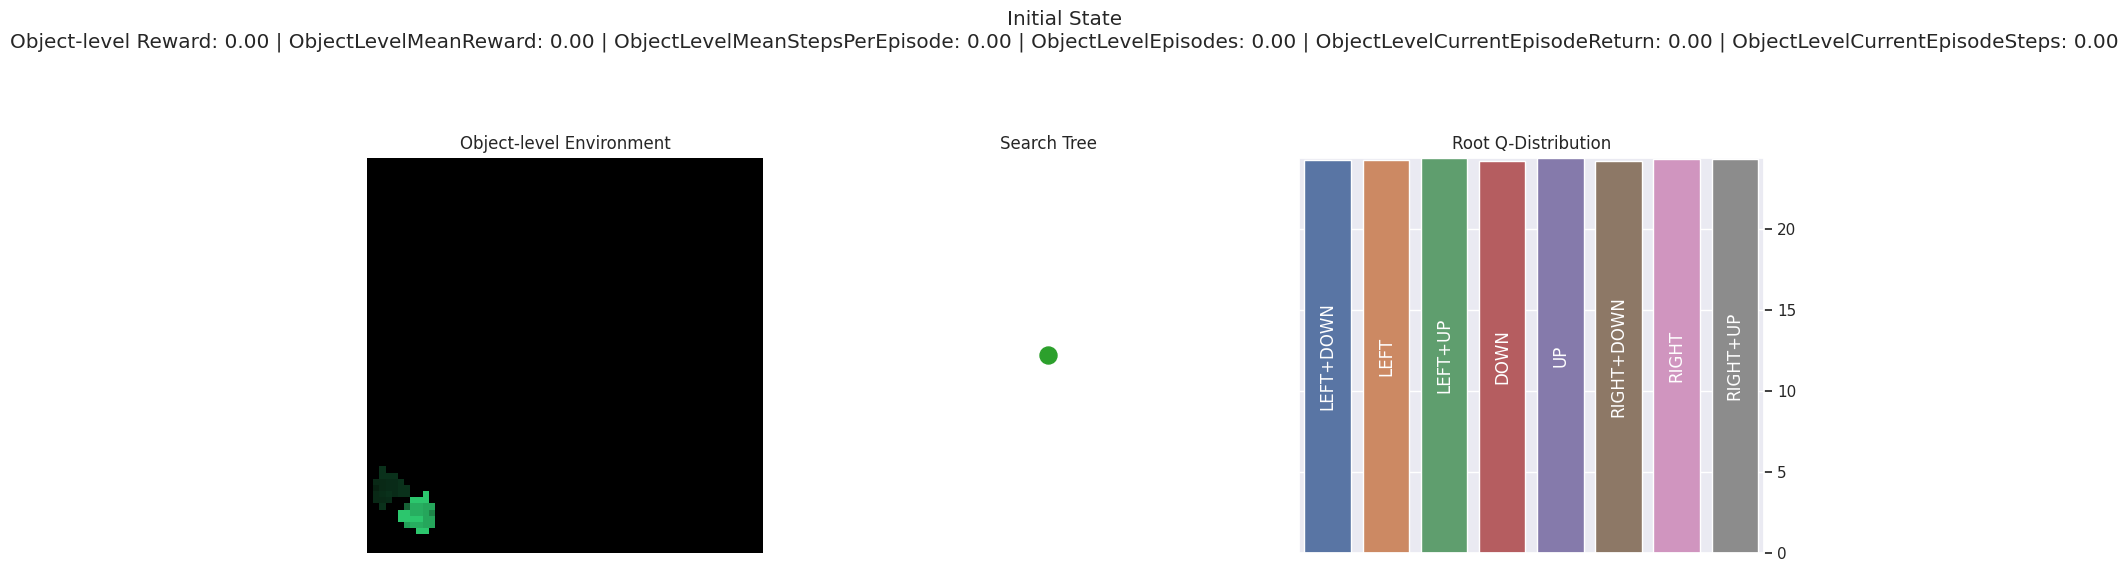

array([[[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       ...,

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        ...,
        [255, 255, 255, 255],
        [255, 255, 255, 255],
        [255, 255, 255, 255]],

       [[255

In [31]:
# meta_env.step(1)
sns.set(font_scale=2)
meta_env.render(plt_show=True);

In [32]:
reset_object_level_metrics(batched_meta_env)
eval_results = eval_runner.run()
object_level_results = get_object_level_metrics(batched_meta_env)

evaluations = {
    **args,
    **object_config,
    **eval_results,
    **object_level_results
}


30/30 [==============================] - 8s 262ms/step - AverageReturn: 0.0467
Evaluation stats:
EvalTime: 7.725


In [9]:
from mlrl.utils.render_utils import save_video, embed_mp4

embed_mp4(save_video(observer.frames[0], fps=1))

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import json
import yaml
from pathlib import Path

%matplotlib inline
sns.set()

In [2]:
# episode_stats_df = pd.concat([
#     pd.read_csv(os.path.join(baselines_eval_folder, 'episode_stats.csv')),
#     *[pd.read_csv(os.path.join(folder, 'episode_stats.csv')) for folder in learned_eval_folders]
# ]).reset_index()

episode_stats_df = pd.concat([
    pd.read_csv('outputs/baseline/procgen/final/episode_stats.csv'),
    *[pd.read_csv(p) for p in Path('outputs/eval/procgen/final').glob('episode_stats*')]
]).reset_index()

# for consistent hue order
policy_hue_order = episode_stats_df['Meta-level Policy'].unique()

# results_df = pd.concat([
#     pd.read_csv(os.path.join(baselines_eval_folder, 'results.csv')),
#     pd.read_csv(os.path.join(learned_eval_folders[0], 'results2.csv')),
#     *[pd.read_csv(os.path.join(folder, 'results.csv')) for folder in learned_eval_folders]
# ]).reset_index()

In [3]:
episode_stats_df.head()

,index,Run ID,Meta-level Policy,Pretrained Percentile,Number of Steps,Return
0,0,NaN,AStar,0.25,29,0.0
1,1,NaN,AStar,0.25,322,54.0
2,2,NaN,AStar,0.25,500,117.0
3,3,NaN,AStar,0.25,500,107.0
4,4,NaN,AStar,0.25,500,111.0


In [4]:
episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
means_df

,Meta-level Policy,Pretrained Percentile,index,Number of Steps,Return
0,AStar,0.25,8.000000,461.823529,97.235294
1,AStar,0.50,503.500000,488.125000,102.666667
2,AStar,0.75,527.500000,485.958333,113.250000
3,AStar,0.90,428.500000,500.000000,116.541667
4,Instant Terminate,0.25,66.500000,136.040000,16.240000
5,Instant Terminate,0.50,166.500000,184.230000,20.450000
6,Instant Terminate,0.75,266.500000,227.230000,28.790000
7,Instant Terminate,0.90,366.500000,230.400000,35.980000
8,Learned Meta-Policy,0.25,9.500000,490.750000,115.550000
9,Learned Meta-Policy,0.50,9.500000,489.925000,120.950000


In [14]:
episodes_df['Meta-level Policy'].unique()

array(['Instant Terminate', 'Random', 'AStar', 'Learned Meta-Policy'],
      dtype=object)

In [20]:

pallete

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

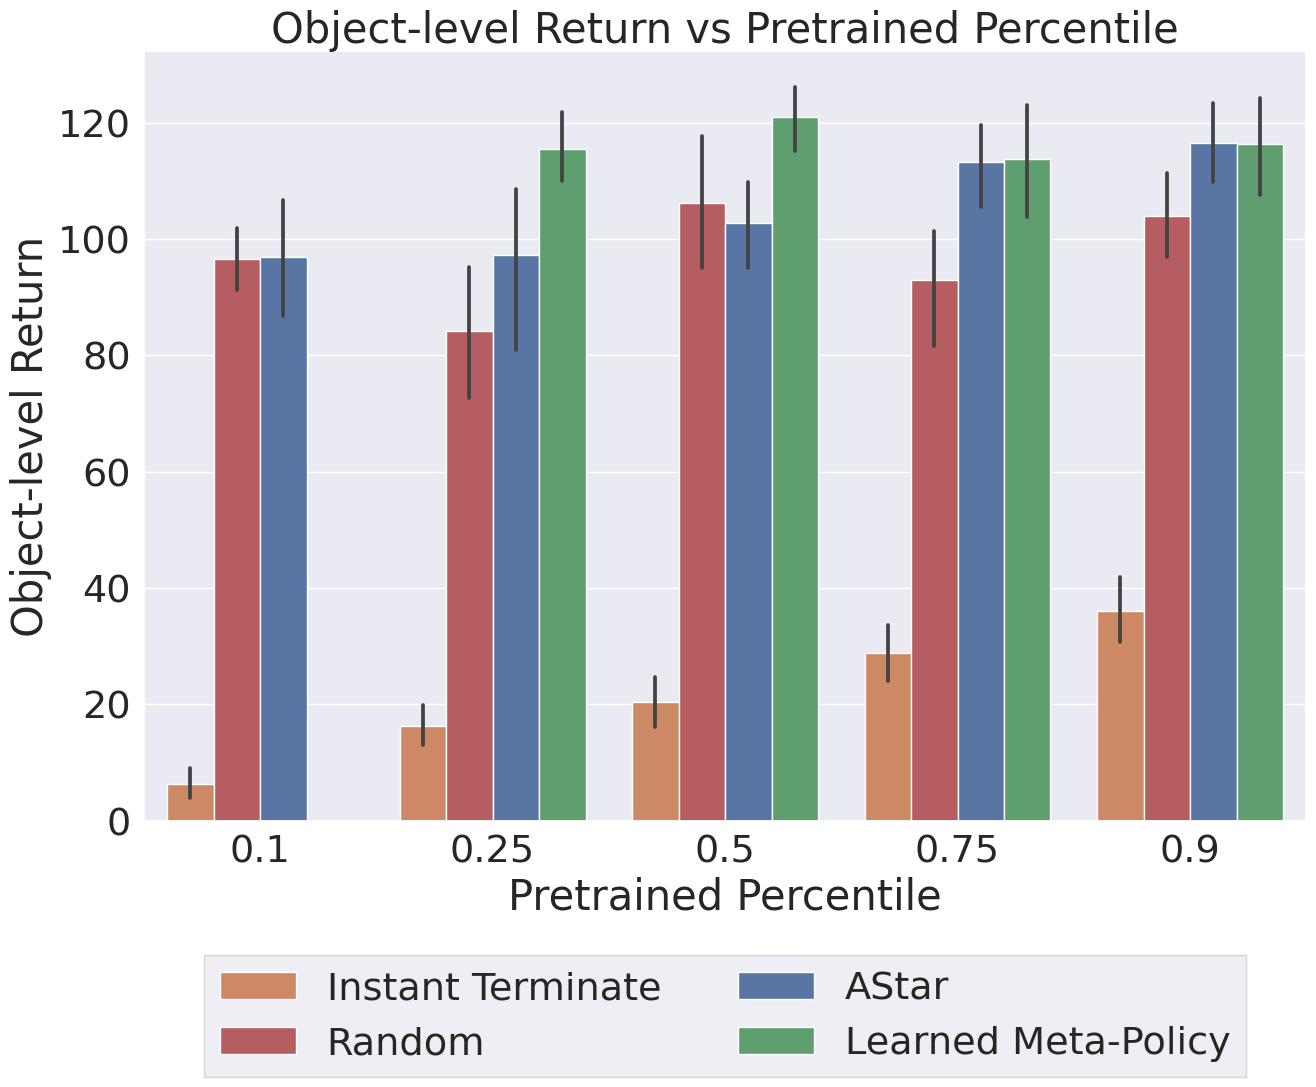

In [44]:
sns.set(font_scale=2.5)

plt.figure(figsize=(15, 10))

episode_stats_df = pd.concat([
    pd.read_csv('outputs/baseline/procgen/final/episode_stats.csv'),
    *[pd.read_csv(p) for p in Path('outputs/eval/procgen/final').glob('episode_stats*')]
]).reset_index()

episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
policy_rank = ['Instant Terminate', 'Random', 'AStar', 'Learned Meta-Policy']
pallete = sns.color_palette()
policy_pallete = [pallete[1], pallete[3], pallete[0], pallete[2]]

ax = sns.barplot(data=episodes_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy',
                 hue_order=policy_rank, palette=policy_pallete)

plt.ylabel('Object-level Return')
plt.title(f'Object-level Return vs Pretrained Percentile')

ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=2, fancybox=False, shadow=False)


plt.show()

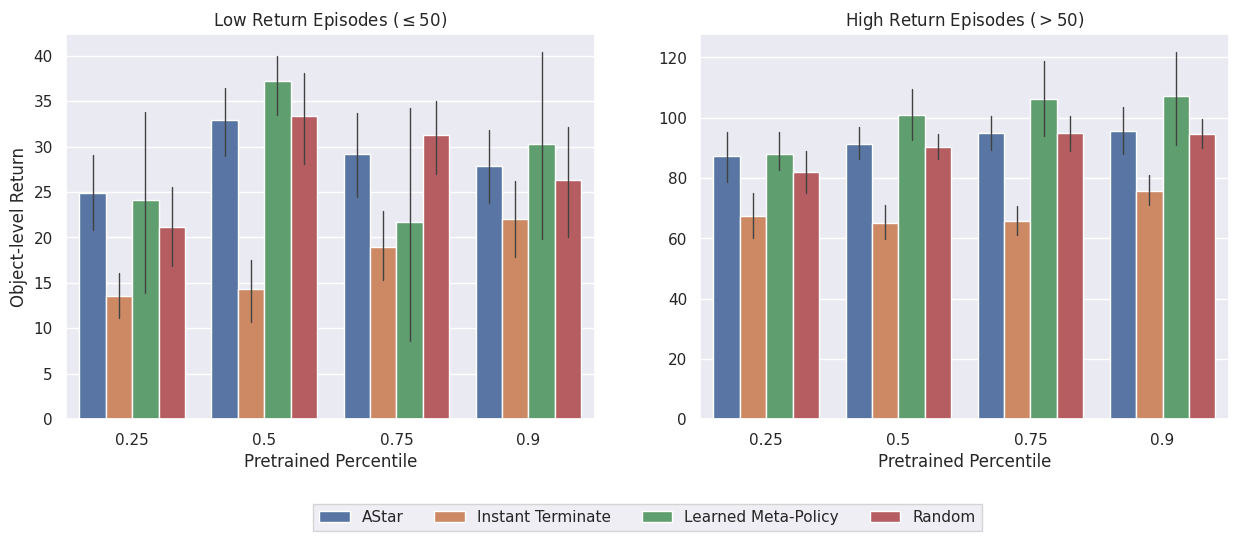

In [150]:
sns.set(font_scale=1)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

return_t = 50

episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Return'] <= return_t]
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
means_df.sort_values(by='Meta-level Policy', inplace=True)
episodes_df.sort_values(by='Meta-level Policy', inplace=True)
policy_hue_order = episodes_df['Meta-level Policy'].unique()

sns.barplot(data=episodes_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy',
            ax=axs[0], hue_order=policy_hue_order, errwidth=1)

axs[0].set_ylabel('Object-level Return')
axs[0].set_title(f'Low Return Episodes ($\leq {return_t}$)')

axs[0].legend(loc='upper center', bbox_to_anchor=(1.1, -.2),
              ncol=4, fancybox=False, shadow=False)


episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Return'] > return_t]
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
means_df.sort_values(by='Meta-level Policy', inplace=True)
episodes_df.sort_values(by='Meta-level Policy', inplace=True)

sns.barplot(data=episodes_df, x='Pretrained Percentile', y='Return', hue='Meta-level Policy',
            ax=axs[1], hue_order=policy_hue_order, errwidth=1)

axs[1].set_ylabel('')
axs[1].set_title(f'High Return Episodes ($> {return_t}$)')
# remove legend
axs[1].legend([],[], frameon=False)

plt.show()

/tmp/ipykernel_12830/3750295276.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Return Interval'] = df['Rounded Return'].apply(lambda x: f'[{x}, {x + n})')
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/tmp/ipykernel_12830/3750295276.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

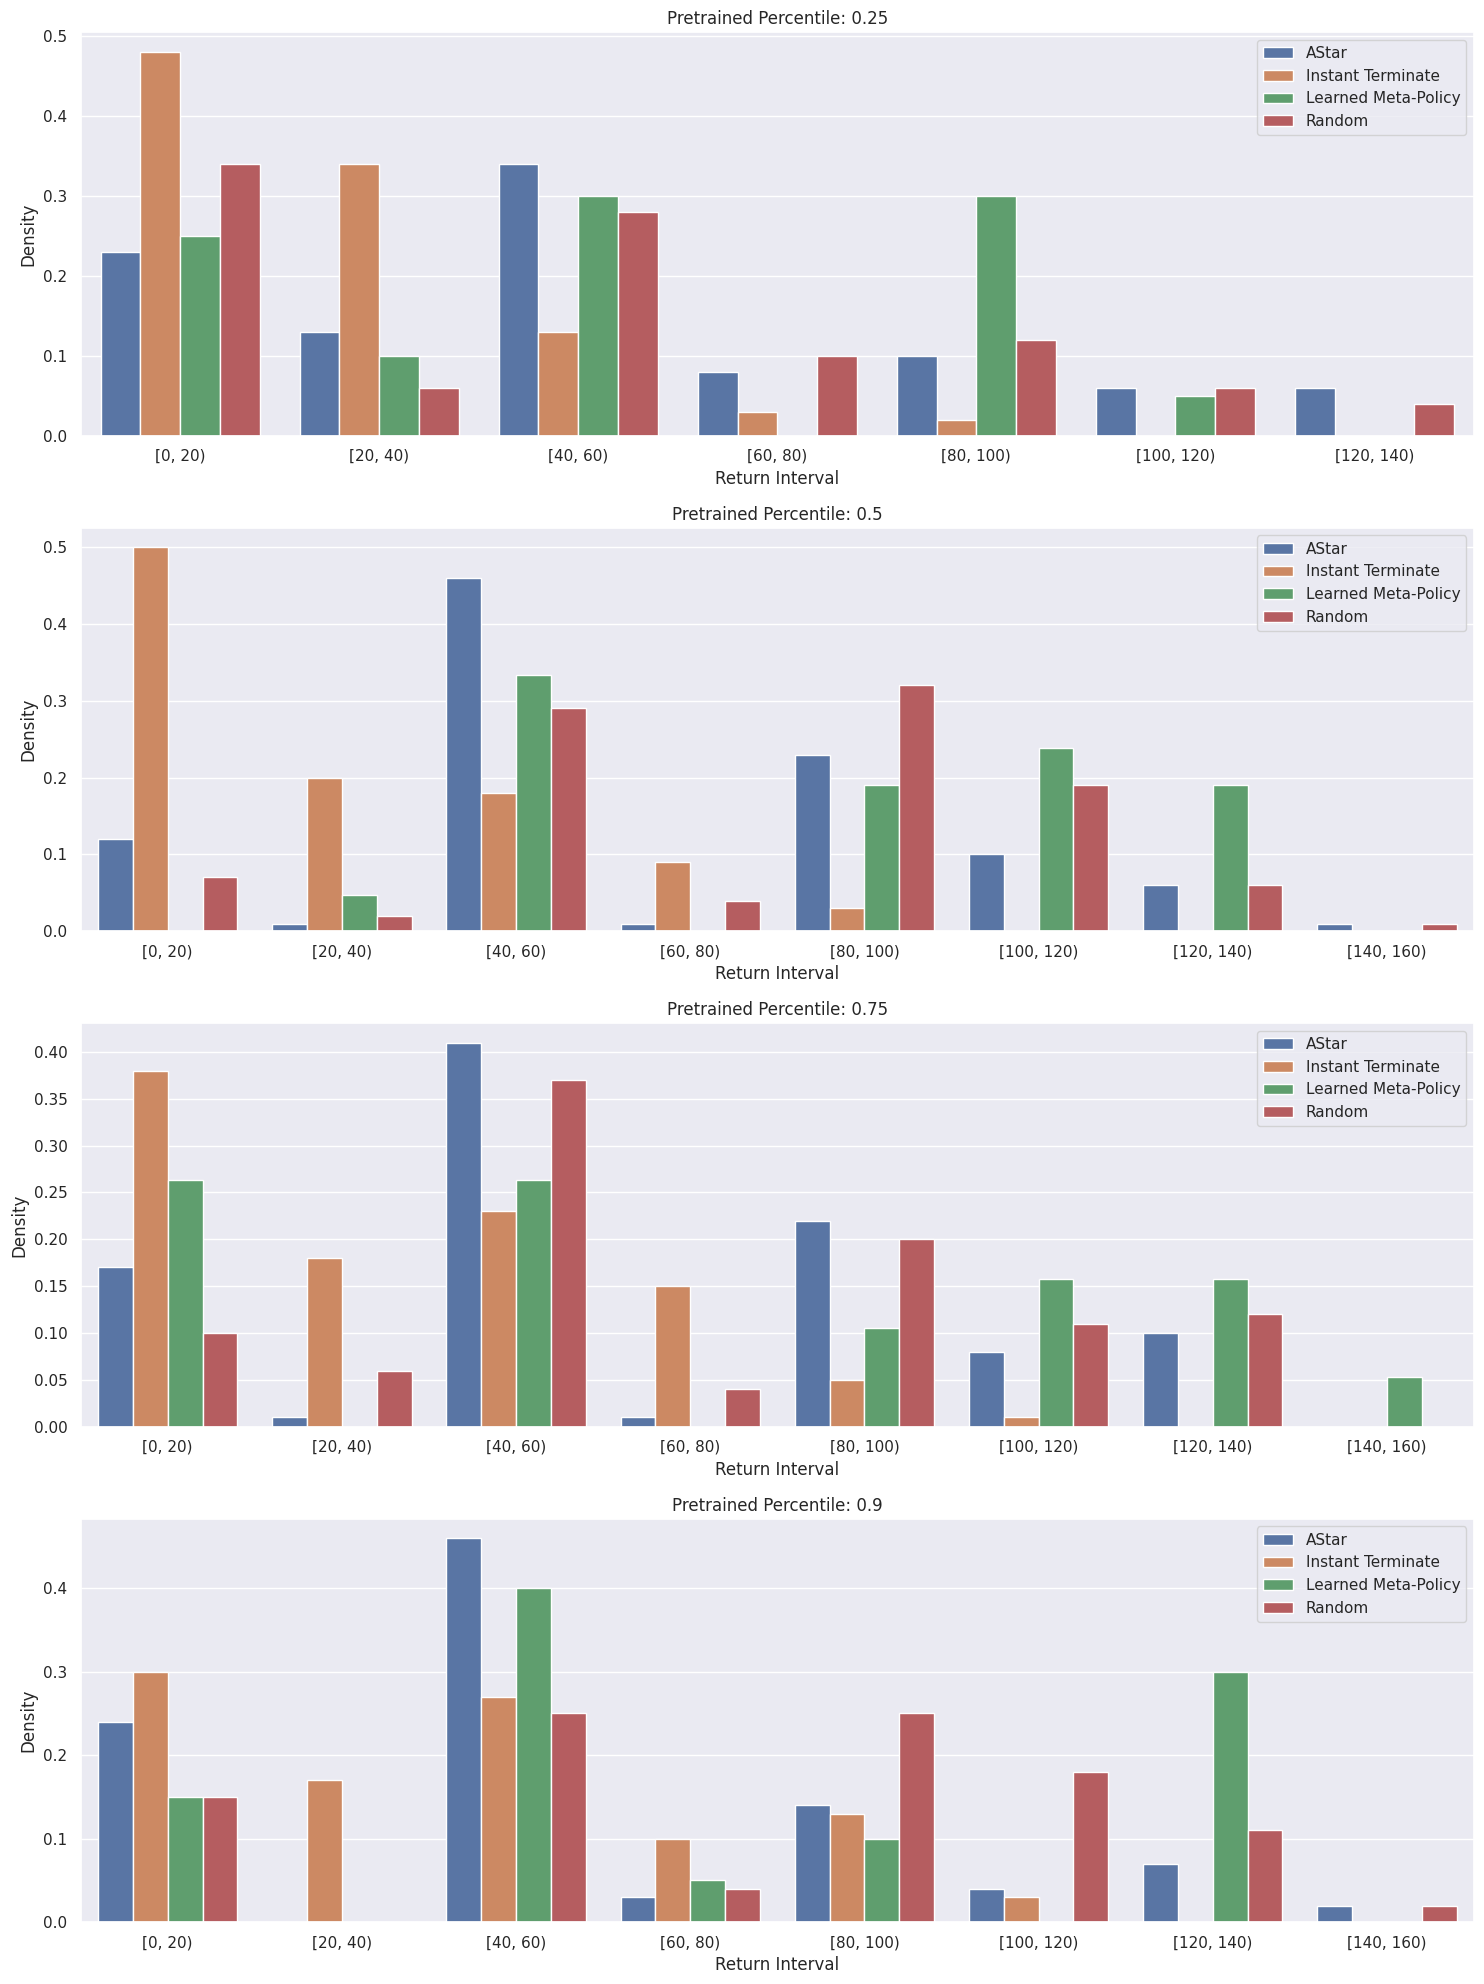

In [141]:
sns.set(font_scale=1)

episodes_df = episode_stats_df.copy()
episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
episodes_df.sort_values(by='Meta-level Policy', inplace=True)

n = 20
def round_return(x):
    return round(x / n) * n

episodes_df['Rounded Return'] = episodes_df['Return'].apply(round_return)
counts_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile', 'Rounded Return']).count().reset_index()
counts_df.rename(columns={'Return': 'Count'}, inplace=True)
counts_df.drop(columns=['index', 'Number of Steps'], inplace=True)

total_episodes = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).count().reset_index()
total_episodes.rename(columns={'index': 'Count'}, inplace=True)
total_episodes = total_episodes[['Meta-level Policy', 'Pretrained Percentile', 'Count']]

def normalize_counts(row):
    index, data = row
    right_policy = total_episodes['Meta-level Policy'] == data['Meta-level Policy']
    right_percentile = total_episodes['Pretrained Percentile'] == data['Pretrained Percentile']
    n = total_episodes[right_policy & right_percentile]['Count'].values[0]
    data['Density'] = data['Count'] / n
    return data

counts_df = pd.DataFrame(map(normalize_counts, counts_df.iterrows()))


fig, axs = plt.subplots(4, 1, figsize=(15, 20))

for percentile, ax in zip(sorted(episodes_df['Pretrained Percentile'].unique()),axs):
    # right_percentile = episodes_df['Pretrained Percentile'] == percentile
    # for policy in episodes_df['Meta-level Policy'].unique():
    #     right_policy = episodes_df['Meta-level Policy'] == policy
    #     sns.kdeplot(episodes_df[right_percentile & right_policy]['Return'], label=policy, ax=ax)
    df = counts_df[counts_df['Pretrained Percentile'] == percentile]
    df['Return Interval'] = df['Rounded Return'].apply(lambda x: f'[{x}, {x + n})')
    df.sort_values(by=['Rounded Return', 'Meta-level Policy'], inplace=True)
    sns.barplot(data=df, x='Return Interval', y='Density', hue='Meta-level Policy', ax=ax, hue_order=policy_hue_order)
    ax.set_title(f'Pretrained Percentile: {percentile}')
    # ax.set_xlim([0, 80])

    ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [151]:
# episodes_df = episode_stats_df.copy()
# episodes_df = episodes_df[episodes_df['Meta-level Policy'] != 'Random']
# episodes_df['Meta-level Policy'] = episodes_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
# means_df = episodes_df.groupby(['Meta-level Policy', 'Pretrained Percentile']).mean().reset_index()
# means_df.sort_values(by='Meta-level Policy', inplace=True)
# episodes_df.sort_values(by='Meta-level Policy', inplace=True)

# for percentile in episodes_df['Pretrained Percentile'].unique():
#     fig, ax = plt.subplots(figsize=(15, 5))
#     right_percentile = episodes_df['Pretrained Percentile'] == percentile
#     for policy in episodes_df['Meta-level Policy'].unique():
#         right_policy = episodes_df['Meta-level Policy'] == policy
#         sns.kdeplot(episodes_df[right_percentile & right_policy]['Return'], label=policy, ax=ax)
#     ax.set_title(f'Pretrained Percentile: {percentile}')
#     ax.set_xlim([0, 80])
#     ax.legend()
#     plt.show()

Text(0.5, 1.0, 'Mean Meta-level Return vs Pretrained Percentile')

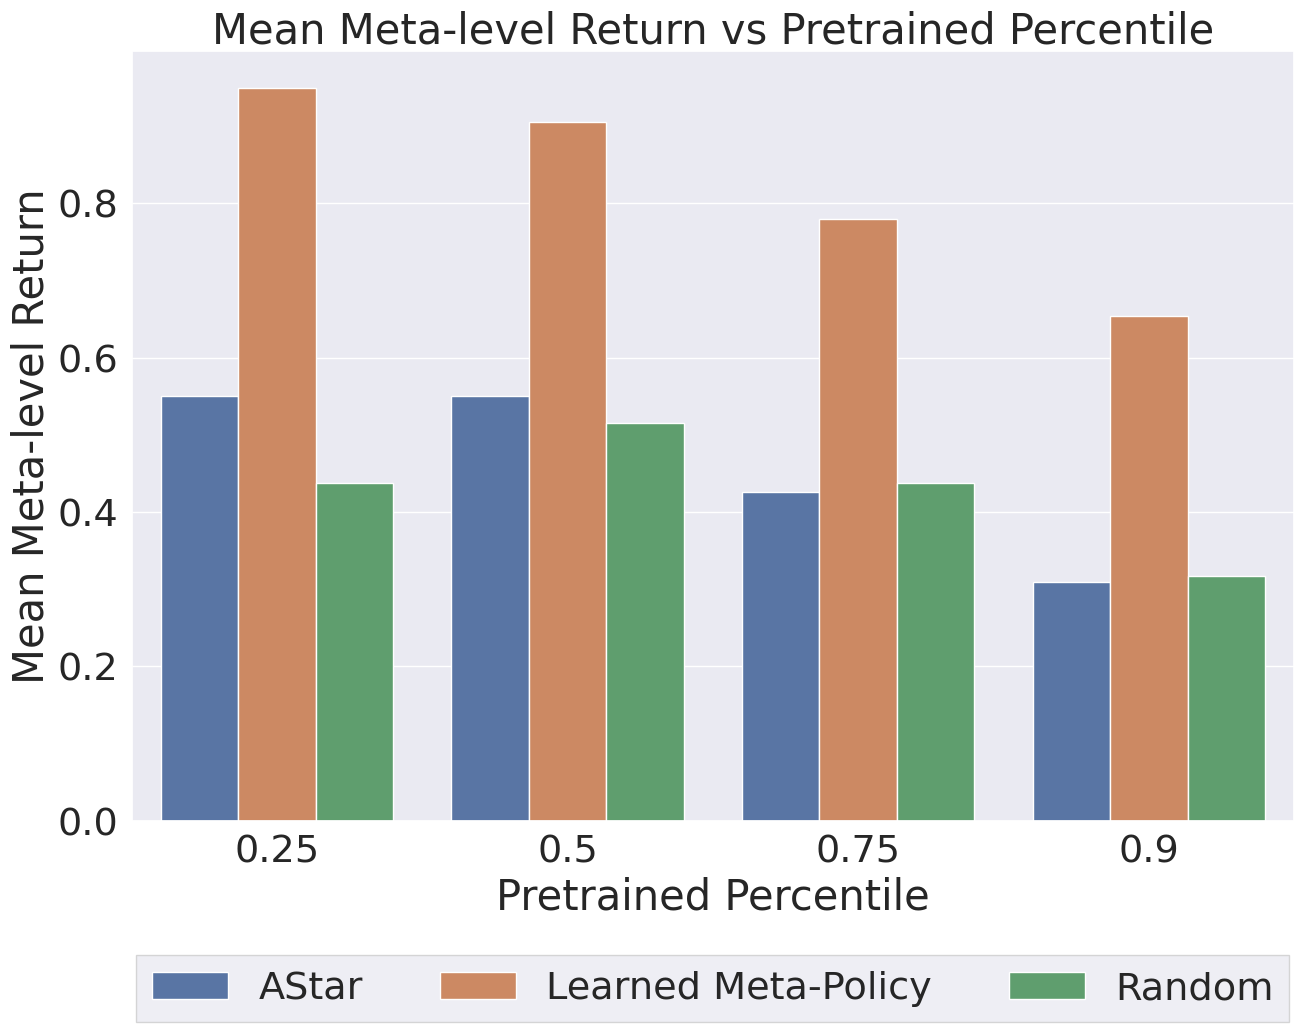

In [170]:

plot_name, plot_key = 'Mean Meta-level Return', 'EvalRewrittenAverageReturn'

plt.figure(figsize=(15, 10))

means_df = results_df.groupby(['Meta-level Policy', 'pretrained_percentile']).mean().reset_index()
means_df = means_df[~means_df['Meta-level Policy'].isin(['Random', 'Instant Terminate'])]
means_df['Meta-level Policy'] = means_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df.sort_values(by='Meta-level Policy', inplace=True)

# sns.lineplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', alpha=0.25)
# ax = sns.scatterplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', legend=False)
ax = sns.barplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', )

ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=3, fancybox=False, shadow=False)

plt.xlabel('Pretrained Percentile')
plt.ylabel(plot_name)
plt.title(f'{plot_name} vs Pretrained Percentile')


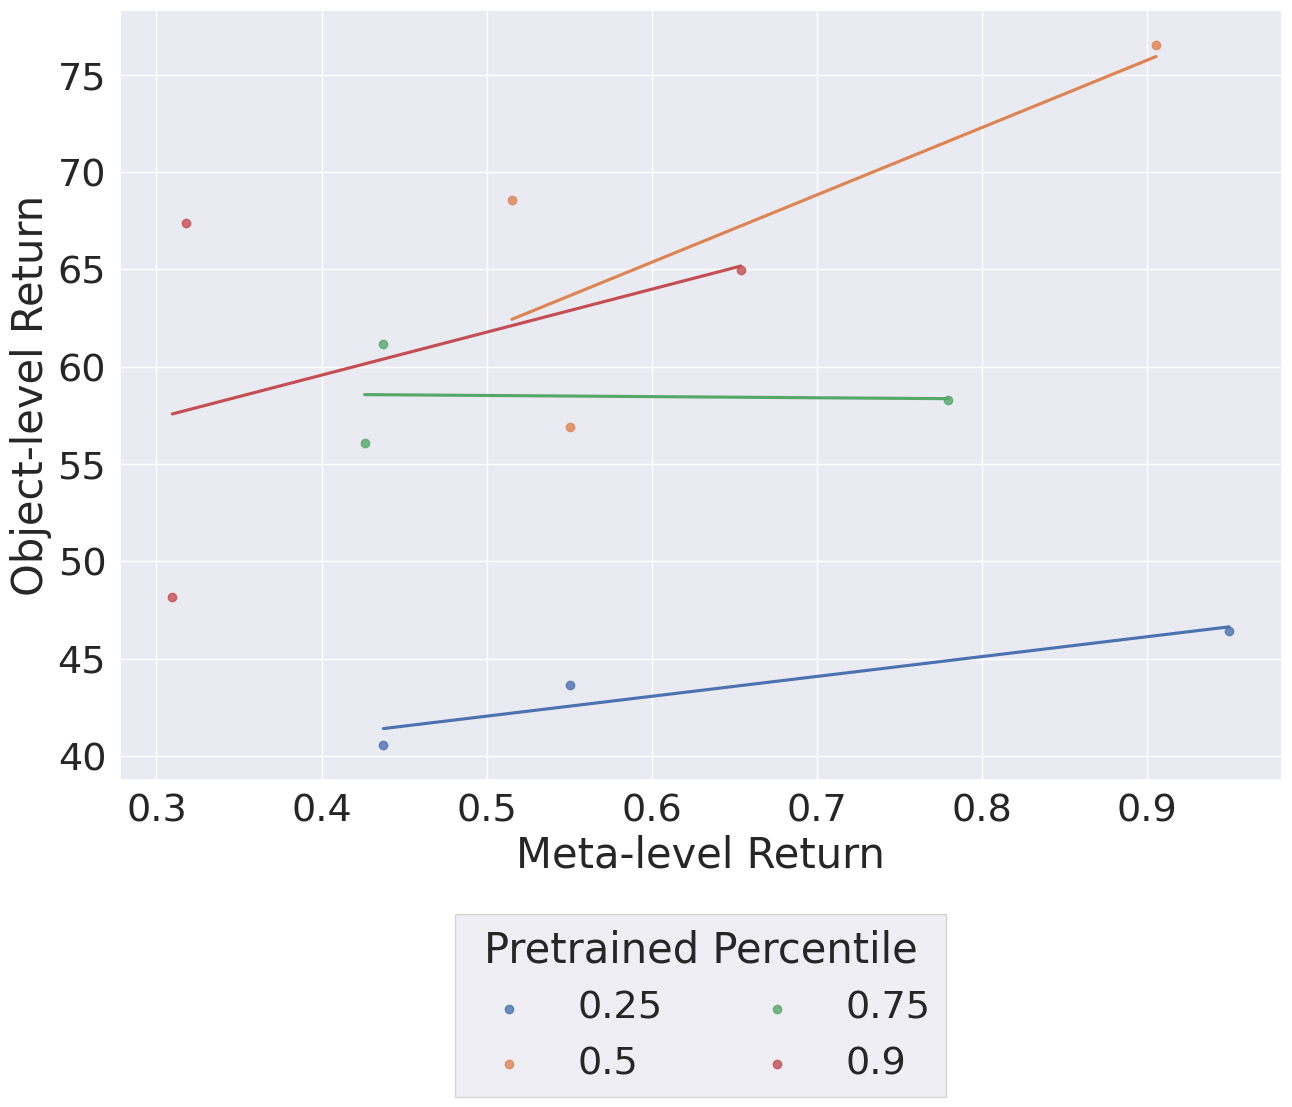

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

In [184]:
means_df = results_df.groupby(['Meta-level Policy', 'pretrained_percentile']).mean().reset_index()
# means_df = means_df[means_df['Meta-level Policy'] != 'Random']
means_df = means_df[~means_df['Meta-level Policy'].isin(['Random', 'Instant Terminate'])]
means_df['Meta-level Policy'] = means_df['Meta-level Policy'].apply(lambda x: 'Random' if 'Random' in x else x)
means_df.sort_values(by='Meta-level Policy', inplace=True)

ax = None
for percentile in means_df['pretrained_percentile'].unique():
    plot_name, plot_key = 'Mean Rewritten Meta Return', 'EvalRewrittenAverageReturn'

    plt.figure(figsize=(15, 10))

    # sns.lineplot(data=means_df, x='pretrained_percentile', y=plot_key, hue='Meta-level Policy', alpha=0.25)
    ax = sns.regplot(data=means_df[means_df['pretrained_percentile'] == percentile], label=percentile,
                x='EvalRewrittenAverageReturn', y='ObjectLevelMeanReward', scatter=True, ci=None, ax=ax)
    # ax = sns.scatterplot(data=means_df, x='EvalRewrittenAverageReturn', y='ObjectLevelMeanReward', hue='pretrained_percentile')

ax.legend(title='Pretrained Percentile', loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=2, fancybox=False, shadow=False)

ax.set_xlabel('Meta-level Return')
ax.set_ylabel('Object-level Return')
plt.show()

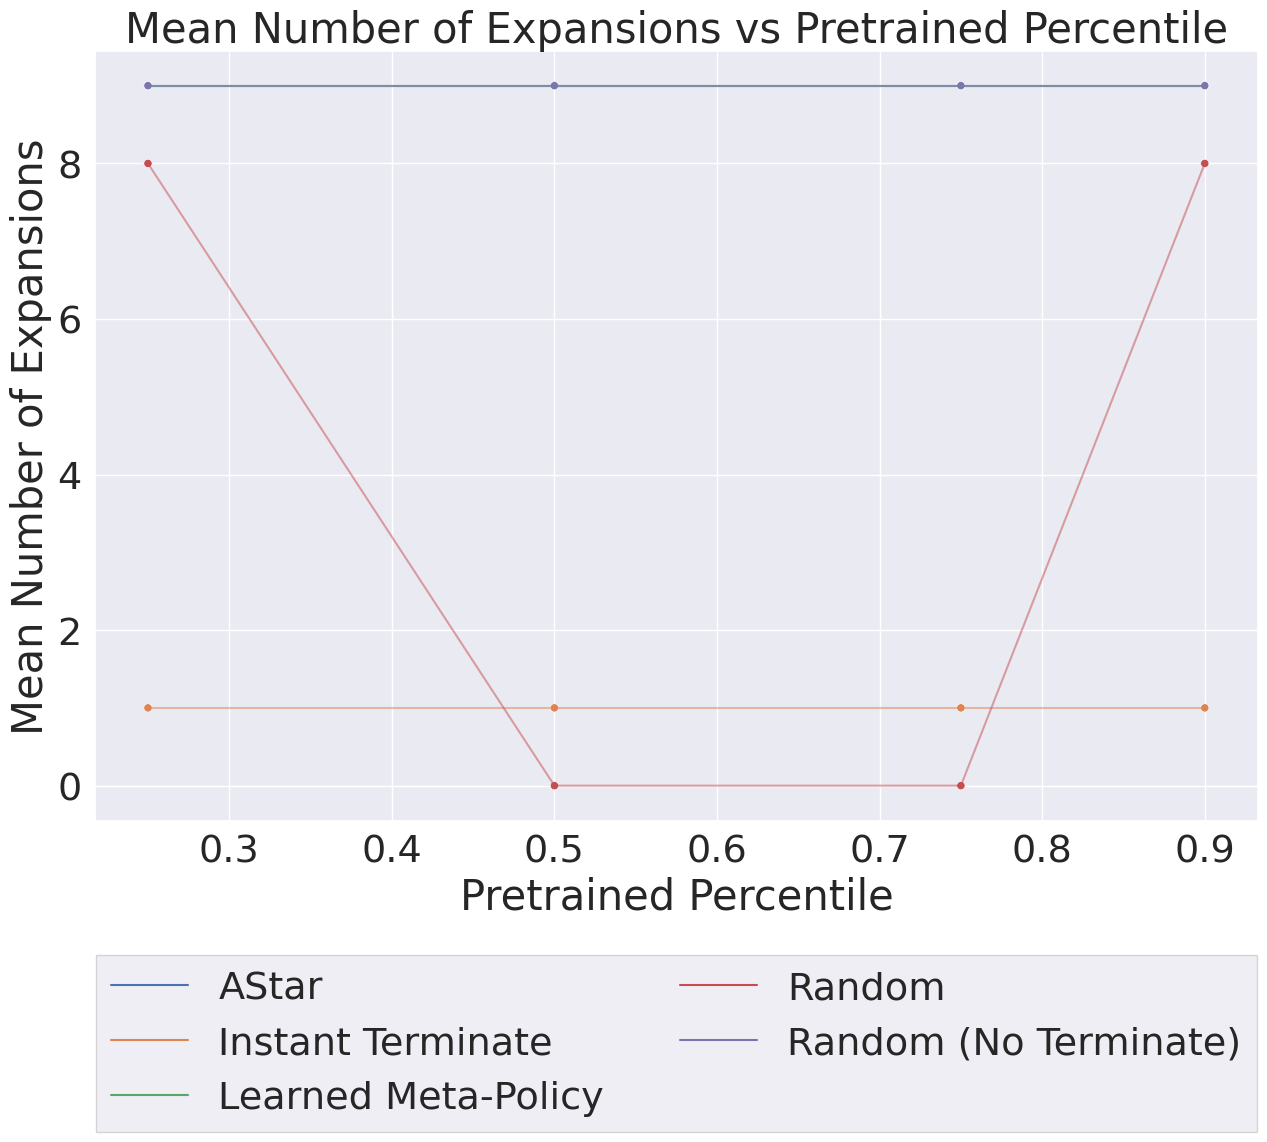

In [135]:
plt.figure(figsize=(15, 10))

means_df = results_df.groupby(['Meta-level Policy', 'pretrained_percentile']).mean().reset_index()
means_df.sort_values(by='Meta-level Policy', inplace=True)

ax = sns.lineplot(data=means_df, x='pretrained_percentile', y='EvalAverageEpisodeLength', hue='Meta-level Policy', alpha=0.5)
sns.scatterplot(data=means_df, x='pretrained_percentile', y='EvalAverageEpisodeLength', hue='Meta-level Policy', legend=False)

plt.xlabel('Pretrained Percentile')

plt.ylabel('Mean Number of Expansions')
plt.title(f'Mean Number of Expansions vs Pretrained Percentile')

# plt.ylim([0, 100])
ax.legend(loc='upper center', bbox_to_anchor=(.5, -.15),
          ncol=2, fancybox=False, shadow=False)

# plt.setp(ax.get_legend().get_texts(), fontsize='10') 
# plt.setp(ax.get_legend().get_title(), fontsize='20') 
# plt.savefig(self.output_dir / 'object-return-vs-percentile.png')

plt.show()